In [1]:
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path

np.random.seed(42)
tf.random.set_seed(42)

model = load_model('C:\\Users\\ABHAY VERMA\\Documents\\Linguistic\\models\\saved_models\handwriting_recognition.h5')

In [2]:
test_samples = list(map(str, Path('C:\\Users\\ABHAY VERMA\\Documents\\Linguistic\\data\\Handwrinting_Recognition\\test_samples').glob('*.png')))

characters = ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
              ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
              'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
              'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

print(f"Total test samples: {len(test_samples)}")

Total test samples: 16


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [4]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(image,paddings=[[pad_height_top, pad_height_bottom],[pad_width_left, pad_width_right],[0, 0]])

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [5]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def process_images(image_path):
    image = preprocess_image(image_path)
    return image


def prepare_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(process_images, num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [6]:
test_ds = prepare_dataset(test_samples)

1/1 [==============================] - 2s 2s/step


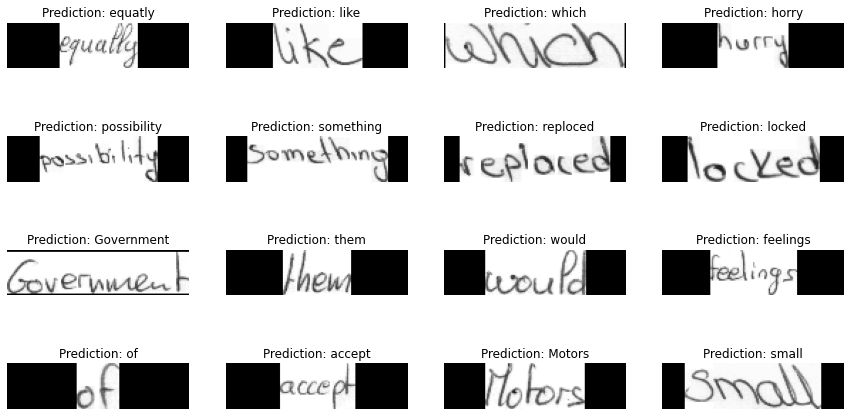

In [7]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = model.predict(batch)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()